In [ ]:
import os
import glob
import random

import torch
import torchvision
import numpy as np
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

from IPython.display import Image

Подключаем cuda

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

## Датасет

Ссылка на датасет - https://www.kaggle.com/datasets/lantian773030/pokemonclassification

Датасет состоит из изображений покемонов, разделенных на классы.

Всего 150 классов.

Изображения изначально разных размеров, приведем изображения к одному размеру 100 на 100 пикселей

In [ ]:
import os
import glob
import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = r'C:\edu\2\NT\PokemonData'
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

class PokemonDataset(Dataset):

    def __init__(self, rootdir, transform=None) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)

    def __len__(self):
        return len(self.images_pathes)

    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)

        if self.transform:
           image = self.transform(image=image)["image"]

        return (image, label)

    def change_transform(self, new_transform):
        self.transform = new_transform

In [ ]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

    def __len__(self):
        return len(self.subset)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


album_transform = A.Compose([
    A.HorizontalFlip(p=0.15),
    A.ElasticTransform(alpha=1.15, sigma=15, alpha_affine=25),
    A.GaussNoise(p=0.25),
    A.Blur(blur_limit=1),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.5, std = 0.5)
    ]
)

simple_transform = A.Compose([
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

In [ ]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

Оригинальный датасет не разделен на тренировочную и тестовую выборки, поэтому разделим датасет в соотношении 80 на 20

In [ ]:
TEST_SIZE = 0.2
BATCH_SIZE = 32
SEED = 42

In [ ]:
dataset = PokemonDataset(DATA_PATH)

In [ ]:
generator = torch.Generator().manual_seed(SEED)

train_dataset, test_dataset = random_split(dataset, [1-TEST_SIZE, TEST_SIZE], generator=generator)

In [ ]:
train_modified_dataset = TransformDataset(train_dataset, album_transform)
test_modified_dataset = TransformDataset(test_dataset, simple_transform)

In [ ]:
train_loader = DataLoader(train_modified_dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(test_modified_dataset, batch_size=BATCH_SIZE)

In [ ]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break


torch.Size([32, 3, 200, 200])
tensor([ 62,  61,  27, 143, 101,  39, 142,  75,  56,  46,  33,  81,  44,  41,
         61,  74,  94,  76,  33,  57, 131,  19, 105, 118,  90, 125,  88,  78,
         87, 112, 146, 145])


In [ ]:
def plot_imgs(data_loader):
    plt.rcParams.update({'font.size': 10})
    fig = plt.figure(figsize=(5, 5))
    columns = 2
    rows = 2
    for i in range(columns*rows):
        for x, y in data_loader:
            img = (x[i].numpy().transpose(1, 2, 0) + 1) / 2
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #plt.figure(figsize=(6, 6))
            #plt.axis('off')
            a = fig.add_subplot(rows, columns, i+1)
            plt.axis('off')
            plt.imshow((img*255).astype('int32'))
            a.set_title(classes[int(y[i])])
            #plt.title(classes[int(y[i])])
            break
    plt.show()

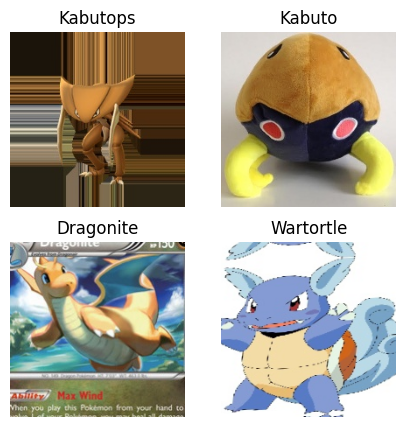

In [ ]:
plot_imgs(train_loader)

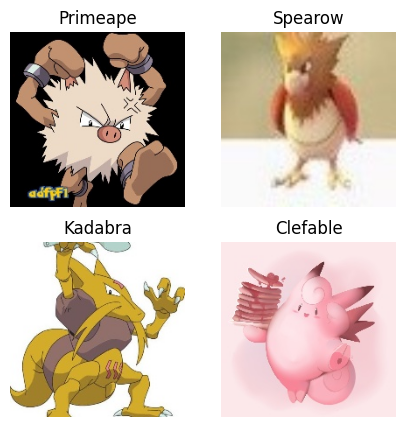

In [ ]:
plot_imgs(test_loader)

## Модель

In [ ]:
print(f"Кол-во классов: {len(classes.values())}")

Кол-во классов: 150


In [ ]:
print(229//2)

114


Имеем входной тензор 200 на 200.

Вычисляем кол-во нейронов на полносвязном слое.

(200 - 3 + 1) // 2 = 99

(99 - 3 + 1) // 2 = 48

(48 - 3 + 1) // 2 = 23

32 * 23 * 23 = 16928

In [ ]:
class PokemonClassificator(nn.Module):
    def __init__(self):
        super(PokemonClassificator, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (3,3), 1)
        self.avPoll_1 = nn.AvgPool2d((2,2), 2)
        self.conv_2 = nn.Conv2d(8, 16, (3,3), 1)
        self.avPoll_2 = nn.AvgPool2d((2,2), 2)
        self.conv_3 = nn.Conv2d(16, 32, (3,3), 1)
        self.avPoll_3 = nn.AvgPool2d((2,2), 2)
        self.linear_1 = nn.Linear(16928, 1024)
        self.linear_2 = nn.Linear(1024, 150)


    def forward(self, x):
        x = self.conv_1(x)
        x = F.tanh(x)
        x = self.avPoll_1(x)
        x = F.tanh(x)

        x = self.conv_2(x)
        x = F.tanh(x)
        x = self.avPoll_2(x)
        x = F.tanh(x)

        x = self.conv_3(x)
        x = F.tanh(x)
        x = self.avPoll_3(x)
        x = F.tanh(x)

        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)

        return x

In [ ]:
class CSPBlock(nn.Module):
    def __init__(self, input_channel):
        super(CSPBlock, self).__init__()
        self.conv_1 = nn.Conv2d(input_channel//2, input_channel//2, (1,1), 1, padding = 0)
        self.conv_3 = nn.Conv2d(input_channel//2, input_channel//2, (3,3), 1, padding = 1)

    def forward(self, x):
        in_chanel = x.size(1)
        x1 = x[:,:in_chanel//2, :, :]
        x2 = x[:,in_chanel//2:, :, :]
        x1 = self.conv_1(x1)
        x1 = F.relu(x1)
        x1 = self.conv_3(x1)
        x1 = F.relu(x1)
        x = torch.cat((x1, x2),dim=1)

        return x

In [ ]:
class PokemonClassificator_CSP(nn.Module):
    def __init__(self):
        super(PokemonClassificator_CSP, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (3,3), 1)
        self.csp_1 = CSPBlock(8)
        self.avPoll_1 = nn.AvgPool2d((2,2), 2)
        self.conv_2 = nn.Conv2d(8, 16, (3,3), 1)
        self.csp_2 = CSPBlock(16)
        self.avPoll_2 = nn.AvgPool2d((2,2), 2)
        self.conv_3 = nn.Conv2d(16, 32, (3,3), 1)
        self.csp_3 = CSPBlock(32)
        self.avPoll_3 = nn.AvgPool2d((2,2), 2)
        self.linear_1 = nn.Linear(32 * 23 * 23, 1024)
        self.linear_2 = nn.Linear(1024, 150)

    def forward(self, x):

        x = self.conv_1(x)
        x = F.tanh(x)
        x = self.csp_1(x)
        x = self.avPoll_1(x)

        x = self.conv_2(x)
        x = F.tanh(x)
        x = self.csp_2(x)
        x = self.avPoll_2(x)
        x = F.tanh(x)

        x = self.conv_3(x)
        x = F.tanh(x)
        x = self.csp_3(x)
        x = self.avPoll_3(x)
        x = F.tanh(x)

        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)

        return x

In [ ]:
model = PokemonClassificator_CSP()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.0001,)

In [ ]:
import tqdm

In [ ]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)

    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    acc = 0
    loss = 0
    for ep in range(epoch):
        print("epoch: ", ep+1)
        for step, (x, y) in tqdm.tqdm(enumerate(dataloader)):
            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*BATCH_SIZE

        acc = val(model, test_loader)
        print(f"loss = {loss}")
        print('precision =', acc)


    return acc


In [ ]:
accuracy = train(train_loader, model, loss_function, optimizator, 10)

epoch:  1


167it [00:30,  5.44it/s]


loss = 3.9416537284851074
precision = 0.1179564237415477
epoch:  2


167it [00:30,  5.44it/s]


loss = 3.0408122539520264
precision = 0.24117205108940645
epoch:  3


167it [00:30,  5.42it/s]


loss = 2.247497797012329
precision = 0.33283245679939893
epoch:  4


167it [00:31,  5.37it/s]


loss = 1.8393547534942627
precision = 0.39293764087152516
epoch:  5


167it [00:30,  5.44it/s]


loss = 1.4059690237045288
precision = 0.4229902329075883
epoch:  6


167it [00:30,  5.39it/s]


loss = 1.1654760837554932
precision = 0.4530428249436514
epoch:  7


167it [00:30,  5.51it/s]


loss = 0.786836564540863
precision = 0.4695717505634861
epoch:  8


167it [00:30,  5.49it/s]


loss = 0.47609931230545044
precision = 0.47483095416979715
epoch:  9


167it [00:30,  5.55it/s]


loss = 0.6150272488594055
precision = 0.4906085649887303
epoch:  10


167it [00:30,  5.48it/s]


loss = 1.0741773843765259
precision = 0.49586776859504134


Сохраним модель, указав датасет, кол-во эпох и точность

In [ ]:
accuracy = (accuracy*100)
output_str = f"pokemon_200_csp_classifier_10_{accuracy:.2f}"
output_str = output_str.replace(".", "_")
output_str = output_str + '.pt'
print(output_str)

pokemon_200_csp_classifier_10_49_59.pt


In [ ]:
torch.save(model, output_str)

## Оценка модели

In [ ]:
model.to('cpu')
model(x).size()

torch.Size([32, 150])

In [ ]:
model.eval()

PokemonClassificator_CSP(
  (conv_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (csp_1): CSPBlock(
    (conv_1): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (avPoll_1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (csp_2): CSPBlock(
    (conv_1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
    (conv_3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (avPoll_2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (csp_3): CSPBlock(
    (conv_1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (conv_3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (avPoll_3): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (linear_1): Linear(in_features=16928, out_features=1024, bias=True)
  (linear_2): Linear(in_fea

In [ ]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to('cpu')), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))


42


Посмотрим ответы модели

С помощью num_in_batch выбираем картинку в первом batch

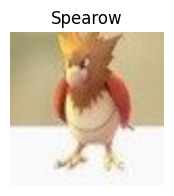

Истинная метка: 127 - Spearow
Предсказ метка: 127 - Spearow


In [ ]:
num_in_batch = 1
for x,y in test_loader:
    # Преобразование значений изображения из диапазона [-1, 1] в диапазон [0, 1]
    img = (x[num_in_batch].numpy().transpose(1, 2, 0) + 1) / 2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    # Преобразование значений изображения из диапазона [0, 1] в диапазон [0, 255] (Перемешались цвет. каналы)
    plt.imshow((img*255).astype('int32'))
    plt.title(classes[int(y[num_in_batch])])
    plt.show()
    print(f'Истинная метка: {y[num_in_batch].numpy()} - {classes[int(y[num_in_batch])]}')
    print(f'Предсказ метка: {predicts[0][num_in_batch]} - {classes[int(predicts[0][num_in_batch])]}')
    break

In [ ]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

Посчитаем метрики: Accuracy, Precision, recall. Посчитаем для каждого класса в бинарном виде каждую метрику и возьмём среднее.

In [ ]:
print(f"Accuracy = {accuracy_score(labels, predicts)}",
    f"\nPrecision = {precision_score(labels, predicts, average=None, zero_division=0).mean()}",
    f"\nRecall = {recall_score(labels, predicts, average=None).mean()}")

Accuracy = 0.49586776859504134 
Precision = 0.5025039018715489 
Recall = 0.4858432493432493


In [ ]:
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))

In [ ]:
cm.shape

(150, 150)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          font_size = 14):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(60, 40))
    plt.rcParams.update({'font.size': font_size})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

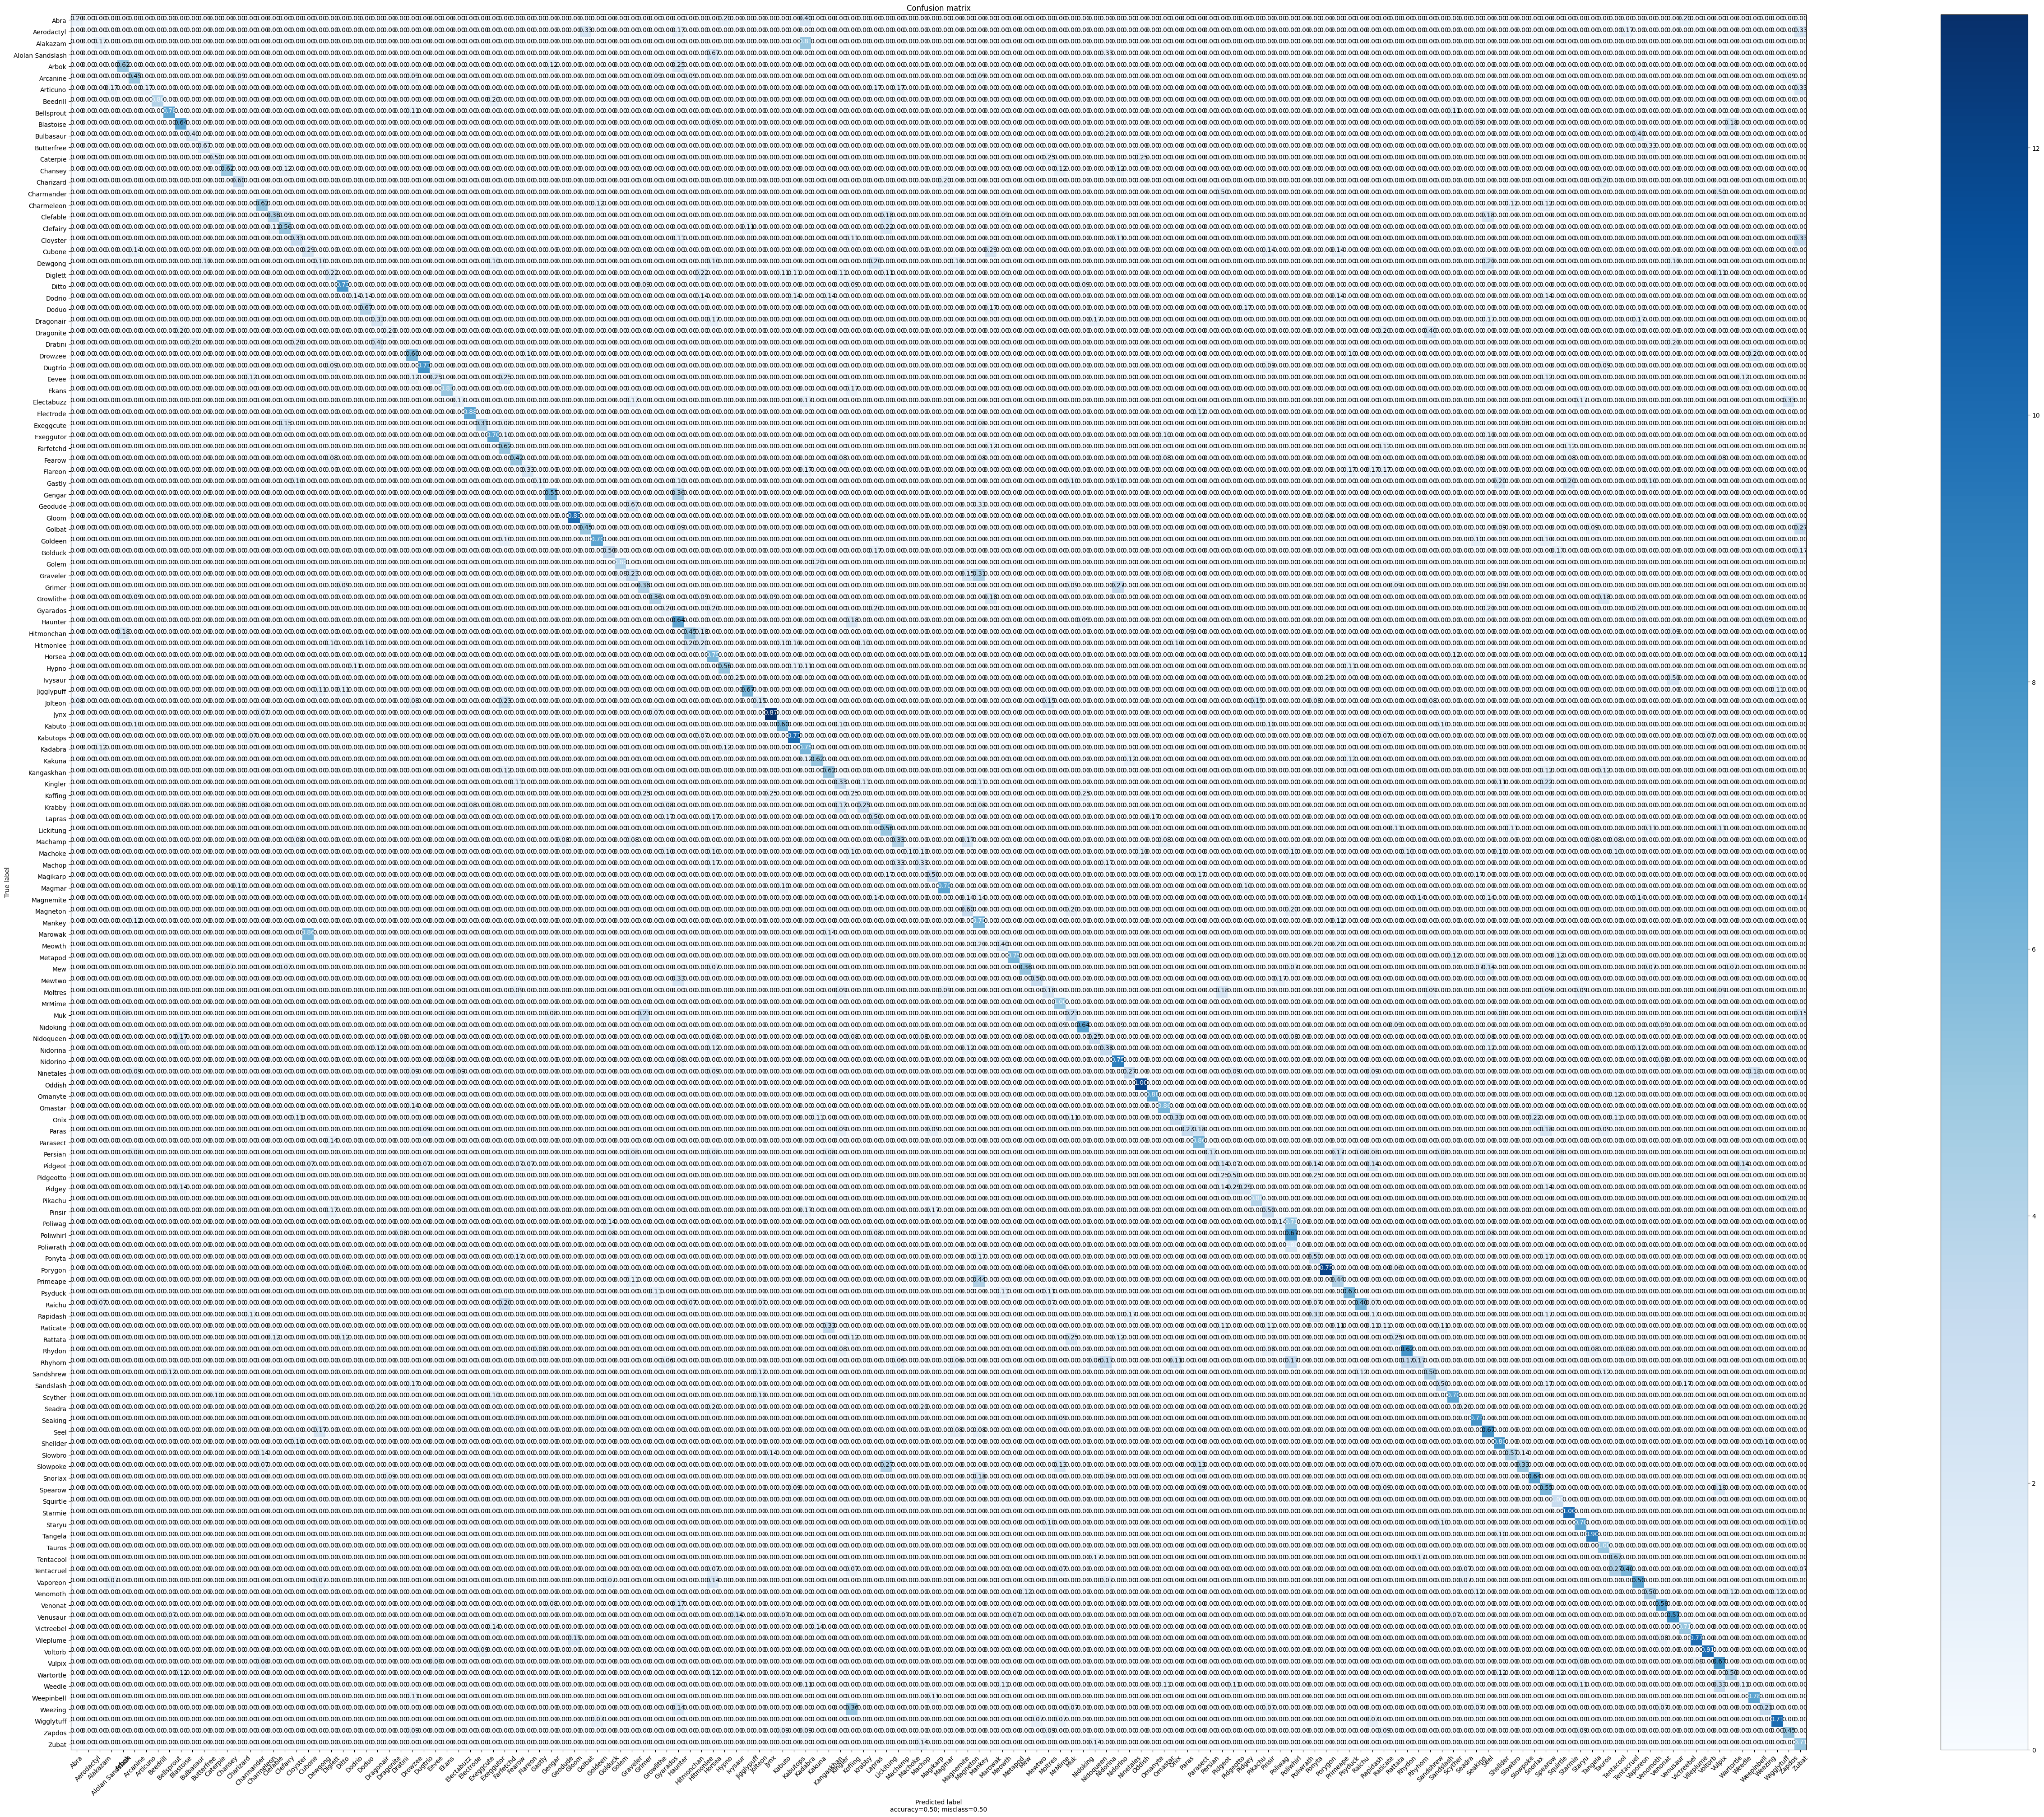

In [ ]:
plot_confusion_matrix(cm, tuple(classes.values()), font_size=10)

C:\Users\Professional\AppData\Local\Temp\ipykernel_14120\3821416726.py:60: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


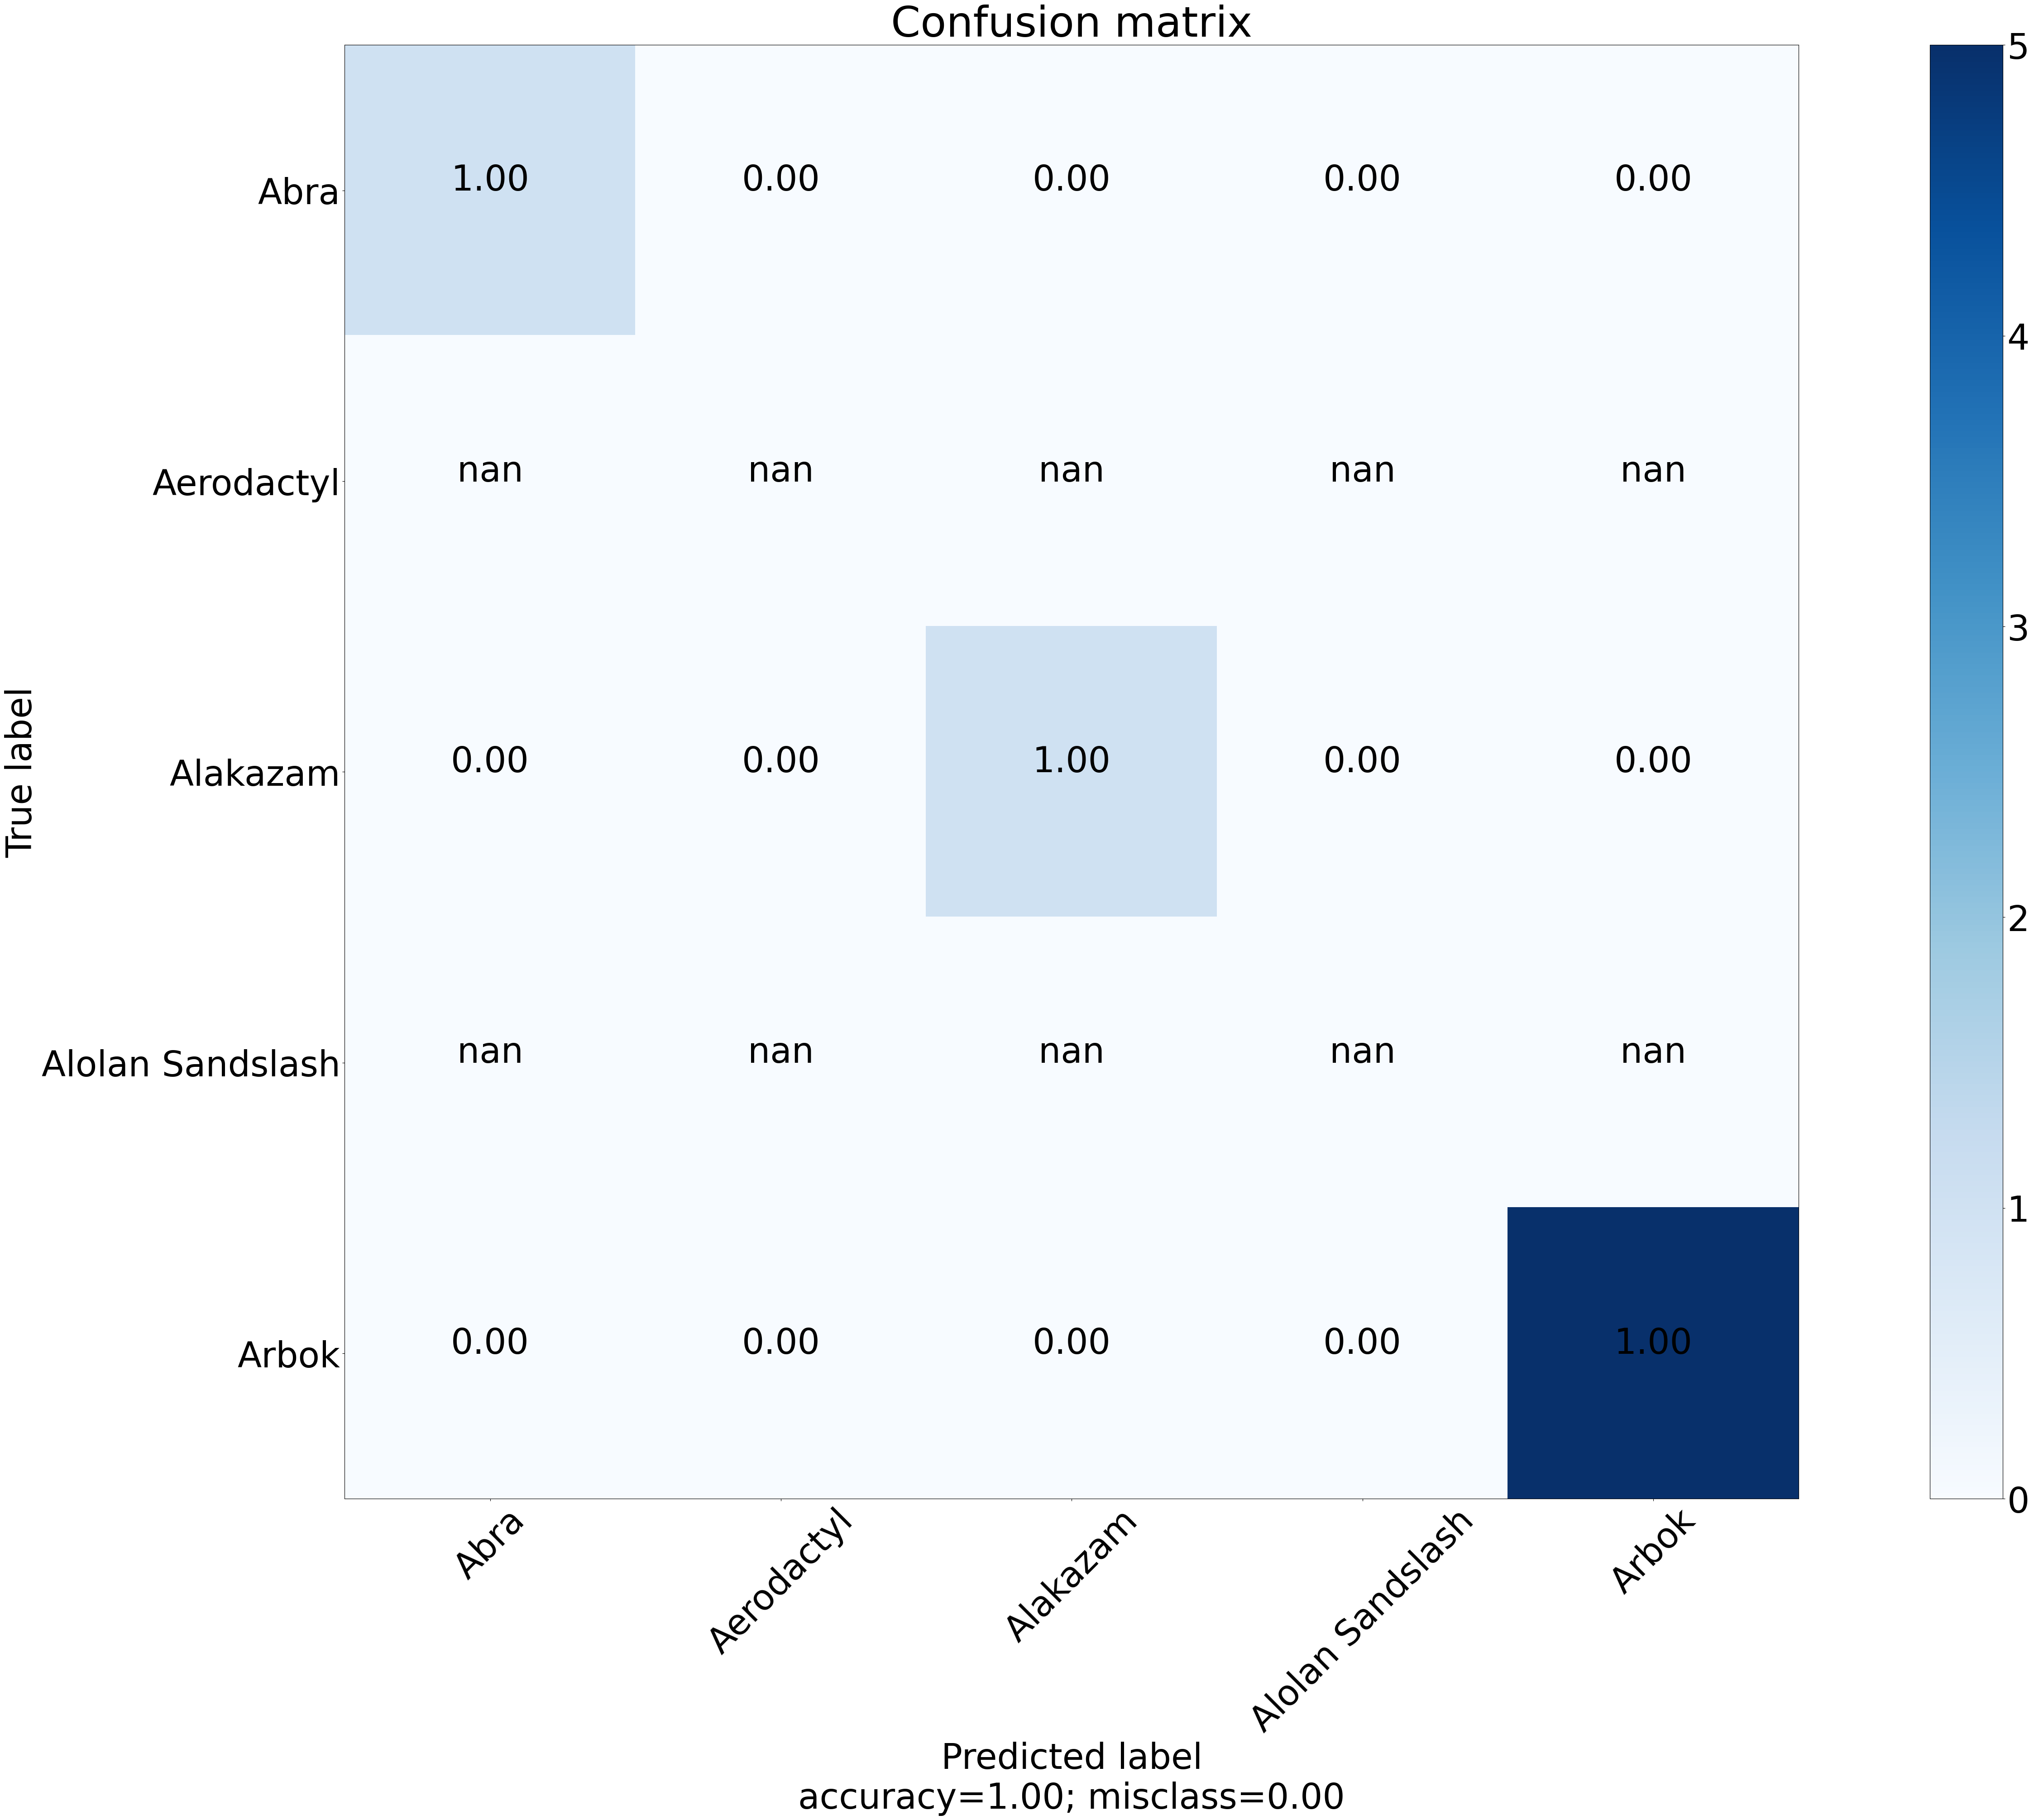

In [ ]:
plot_confusion_matrix(cm[:5,:5], tuple(classes.values())[:5], font_size=56)